In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, concatenate, AveragePooling2D
from tensorflow.keras.layers import Conv2DTranspose, Dropout, Concatenate
from tensorflow.keras.layers import LeakyReLU, Activation, Flatten, Dense, Reshape, InputLayer, Input, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
import cv2
import os
import matplotlib
import keras
import pandas as pd
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from google.colab.patches import cv2_imshow
import math
from math import log10, sqrt
from skimage.metrics import structural_similarity as ssim
from copy import deepcopy
import random
from tensorflow.image import resize

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#train data
try:
  del imageNoise
  del imageClear
except Exception:
  pass
#image with reflects
start_loading = 0
end_loading = 1195
imageNoise = []
for i in range(start_loading, end_loading):
  image = cv2.imread(f'/content/drive/MyDrive/baza/test_base/noise_random_shape_reflect_color/im{i}.jpg')
  if type(image) is not type(None):
    imageNoise.append(image)
imageNoise = np.array(imageNoise, dtype='object')
#image without reflects
imageClear = []
for i in range(start_loading, end_loading):
  image = cv2.imread(f'/content/drive/MyDrive/baza/test_base/clear_for_applied_kernel/im{i}.jpg')
  if type(image) is not type(None):
    imageClear.append(image)
imageClear = np.array(imageClear, dtype='object')

imageNoise = imageNoise.astype('float32') / 255
imageClear = imageClear.astype('float32') / 255

#validation data
try:
  del imageNoise_valid
  del imageClear_valid
except Exception:
  pass
#image with reflects
imageNoise_valid = []
for i in range(0, 520):
  image = cv2.imread(f'/content/drive/MyDrive/baza/test_base/valid/reflects/im{i}.jpg')
  if type(image) is not type(None):
    imageNoise_valid.append(image)
imageNoise_valid = np.array(imageNoise_valid, dtype='object')
imageNoise_valid = imageNoise_valid.astype('float32')
#image without reflects
imageClear_valid = []
for i in range(0, 520):
  image = cv2.imread(f'/content/drive/MyDrive/baza/test_base/valid/true/im{i}.jpg')
  if type(image) is not type(None):
    imageClear_valid.append(image)
imageClear_valid = np.array(imageClear_valid, dtype='object')
imageClear_valid = imageClear_valid.astype('float32')

#imageNoise_valid = np.array([prepare_image( imageClear_valid[idx] ) for idx in range(len(imageClear_valid))], dtype='object')
#dataset normalization
imageNoise_valid = imageNoise_valid / 255.
imageClear_valid = imageClear_valid / 255.

In [ ]:
#model UNet-ssimv2
class My_Model_Arch():
  def __init__(self):
    self.kernel_size = ( 3, 3)
  def __prepare_model(self):
    kernel_size = self.kernel_size
    input = Input((256,256,3))
    conv1 = Conv2D(32, kernel_size = kernel_size, activation = 'relu', padding = 'same')(input)
    conv1_2 = Conv2D(32, kernel_size = kernel_size, activation = 'relu', padding = 'same')(conv1)
    conv1_3 = Conv2D(32, kernel_size = kernel_size, activation = 'relu', padding = 'same')(conv1_2)
    conv_concat = concatenate([conv1, conv1_3], axis = -1)
    conv1= Conv2D(32, kernel_size = kernel_size, activation = 'relu', padding = 'same')(conv_concat)
    pool1 = MaxPooling2D(pool_size = (2,2))(conv1)
    conv2 = Conv2D(64, kernel_size = kernel_size, activation = 'relu', padding = 'same')(pool1)
    conv2 = Conv2D(64, kernel_size = kernel_size, activation = 'relu', padding = 'same')(conv2)
    pool2 = MaxPooling2D(pool_size = (2,2))(conv2)
    conv3 = Conv2D(128, kernel_size = kernel_size, activation = 'relu', padding = 'same')(pool2)
    conv3 = Conv2D(128, kernel_size = kernel_size, activation = 'relu', padding = 'same')(conv3)
    pool3 = MaxPooling2D(pool_size = (2,2))(conv3)
    conv4 = Conv2D(256, kernel_size = kernel_size, activation = 'relu', padding = 'same')(pool3)
    conv4 = Conv2D(256, kernel_size = kernel_size, activation = 'relu', padding = 'same')(conv4)
    pool4 = MaxPooling2D(pool_size = (2,2))(conv4)
    conv5 = Conv2D(512, kernel_size = kernel_size, activation = 'relu', padding = 'same')(pool4)
    conv5 = Conv2D(512, kernel_size = kernel_size, activation = 'relu', padding = 'same')(conv5)
    up6 = Conv2DTranspose(filters = 256, kernel_size=(2,2), strides=(2,2), padding = 'same', activation = 'relu')(conv5)
    up6 = concatenate([ conv4, up6 ] , axis = 3)
    conv6 = Conv2D(256, kernel_size = kernel_size, activation = 'relu', padding = 'same')(up6)
    conv6 = Conv2D(256, kernel_size = kernel_size, activation = 'relu', padding = 'same')(conv6)
    up7 = Conv2DTranspose(filters = 128, kernel_size=(2,2), strides=(2,2), padding = 'same', activation = 'relu')(conv6)
    up7 = concatenate([conv3, up7], axis = 3)
    conv7 = Conv2D(128, kernel_size = kernel_size, activation = 'relu', padding = 'same')(up7)
    conv7 = Conv2D(128, kernel_size = kernel_size, activation = 'relu', padding = 'same')(conv7)
    up8 = Conv2DTranspose(filters = 64, kernel_size=(2,2), strides=(2,2), padding = 'same', activation = 'relu')(conv7)
    up8 = concatenate([conv2, up8], axis = 3)
    conv8 = Conv2D(64, kernel_size = kernel_size, activation = 'relu', padding = 'same')(up8)
    conv8 = Conv2D(64, kernel_size = kernel_size, activation = 'relu', padding = 'same')(conv8)
    up9 = Conv2DTranspose(filters = 32, kernel_size=(2,2), strides=(2,2), padding = 'same', activation = 'relu')(conv8)
    up9 = concatenate([conv1, up9], axis = 3)
    conv9 = Conv2D(filters = 32, kernel_size = kernel_size, activation = 'relu', padding = 'same')(up9)
    output = Conv2D(filters = 3, kernel_size = kernel_size, activation='sigmoid', padding='same')(conv9)
    model = Model(input ,    output)
    return model

  def SSIM(self, x_true, x_pred):
    return tf.image.ssim(x_true, x_pred, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
  def PSNR(self, original_image, reconstructed_image):
    return tf.image.psnr(original_image, reconstructed_image, max_val=1)

  def ssim_loss(self, y_true, y_pred):
    return 1.-tf.image.ssim(y_true, y_pred, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)+1./self.PSNR(y_true, y_pred)

  def make_compiled_model(self):
    model = self.__prepare_model()
    model.compile(loss=self.ssim_loss, optimizer=Adam(learning_rate=0.001), metrics=[self.SSIM, self.PSNR])
    return model

model = My_Model_Arch().make_compiled_model()

In [ ]:
#some test
class TestArch():
  def __init__(self):
    pass

  def __enc_block(self, filters = 32, kernel_size = (2,2), input_layer=None, use_maxpool = False):
    input_layer = input_layer
    if use_maxpool:
      input_layer = BatchNormalization()(input_layer)
      input_layer = MaxPooling2D((2,2))(input_layer)
    conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=(1,1), padding = 'same', activation = 'relu')(input_layer)
    conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=(1,1), padding = 'same', activation = 'relu')(conv)
    return conv

  def __dec_block(self, filters = 32, kernel_size = (3,3), input_layer=None, layer_to_concatenate=None, last_layer = False):
    deconv = Conv2DTranspose(filters=filters, kernel_size = kernel_size, strides = (2,2), padding='same', activation='relu')(input_layer)
    if layer_to_concatenate is not None:
      deconv = concatenate([layer_to_concatenate, deconv])
    conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=(1,1), padding = 'same', activation = 'relu')(deconv)
    if last_layer :
      coonv = Conv2D(filters=3, kernel_size=kernel_size, strides=(1,1), padding = 'same', activation = 'sigmoid')(conv)
    return conv
  def __create_model(self):
    input_layer = Input((256,256,3))
    branch_1_enc_1 = self.__enc_block(filters=32, kernel_size=(3,3), input_layer=input_layer, use_maxpool=False)
    branch_1_enc_2 = self.__enc_block(filters=64, kernel_size=(3,3), input_layer=branch_1_enc_1, use_maxpool=True)
    branch_1_enc_3 = self.__enc_block(filters=128, kernel_size=(3,3), input_layer=branch_1_enc_2, use_maxpool=True)
    branch_1_enc_4 = self.__enc_block(filters=256, kernel_size=(3,3), input_layer=branch_1_enc_3, use_maxpool=True)
    branch_1_enc_5 = self.__enc_block(filters=512, kernel_size=(3,3), input_layer=branch_1_enc_4, use_maxpool=True)
    branch_1_dec_1 = self.__dec_block(filters = 256, input_layer = branch_1_enc_5, layer_to_concatenate=branch_1_enc_4)
    branch_1_dec_2 = self.__dec_block(filters = 128, input_layer = branch_1_dec_1, layer_to_concatenate=branch_1_enc_3)
    branch_1_dec_3 = self.__dec_block(filters = 64, input_layer = branch_1_dec_2, layer_to_concatenate=branch_1_enc_2)
    branch_1_dec_4 = self.__dec_block(filters = 32, input_layer = branch_1_dec_3, layer_to_concatenate=branch_1_enc_1)
    #branch 2
    branch_2_enc_1 = self.__enc_block(filters=32, kernel_size=(3,3), input_layer=input_layer, use_maxpool=False)
    branch_2_enc_2 = self.__enc_block(filters=64, kernel_size=(3,3), input_layer=branch_2_enc_1, use_maxpool=True)
    branch_2_enc_3 = self.__enc_block(filters=128, kernel_size=(3,3), input_layer=branch_2_enc_2, use_maxpool=True)
    branch_2_enc_4 = self.__enc_block(filters=256, kernel_size=(3,3), input_layer=branch_2_enc_3, use_maxpool=True)
    branch_2_dec_1 = self.__dec_block(filters = 128, input_layer = branch_2_enc_4, layer_to_concatenate=branch_2_enc_3)
    branch_2_dec_2 = self.__dec_block(filters = 64, input_layer = branch_2_dec_1, layer_to_concatenate=branch_2_enc_2)
    branch_2_dec_3 = self.__dec_block(filters = 32, input_layer = branch_2_dec_2, layer_to_concatenate=branch_2_enc_1)
    input_concatenation = concatenate([branch_1_dec_4, branch_2_dec_3])
    output_lay = Conv2D(filters=3, kernel_size=(3,3), strides=(1,1), padding = 'same', activation = 'sigmoid')(input_concatenation)
    return Model(input_layer, output_lay)

  def SSIM(self, x_true, x_pred):
    return tf.image.ssim(x_true, x_pred, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)

  def PSNR(self, original_image, reconstructed_image):
    return tf.image.psnr(original_image, reconstructed_image, max_val=1)

  def ssim_loss(self, y_true, y_pred):
    return 1.-tf.image.ssim(y_true, y_pred, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)+1./self.PSNR(y_true, y_pred)
  def make_compilated_model(self):
    model = self.__create_model()
    model.compile(loss=self.ssim_loss, optimizer=Adam(learning_rate=0.001), metrics=[self.SSIM, self.PSNR])
    return model
model = TestArch().make_compilated_model()

In [ ]:
#UNET ssim-v2 training
if imageClear.shape == imageNoise.shape:
  print(imageClear.shape, imageNoise.shape)
  train_history = model.fit(
    imageNoise,
    imageClear,
    epochs=150,
    shuffle=True,
    batch_size = 32,
    validation_data=(imageNoise_valid, imageClear_valid)
)

(1001, 256, 256, 3) (1001, 256, 256, 3)
Epoch 1/150
32/32 [==============================] - 100s 2s/step - loss: 0.4722 - SSIM: 0.6017 - PSNR: 14.7326 - val_loss: 0.3769 - val_SSIM: 0.6911 - val_PSNR: 15.0423
Epoch 2/150
32/32 [==============================] - 57s 2s/step - loss: 0.2376 - SSIM: 0.8113 - PSNR: 21.1471 - val_loss: 0.3311 - val_SSIM: 0.7332 - val_PSNR: 15.8262
Epoch 3/150
32/32 [==============================] - 57s 2s/step - loss: 0.1456 - SSIM: 0.8969 - PSNR: 24.3658 - val_loss: 0.3246 - val_SSIM: 0.7379 - val_PSNR: 16.3858
Epoch 4/150
32/32 [==============================] - 57s 2s/step - loss: 0.1105 - SSIM: 0.9273 - PSNR: 27.2570 - val_loss: 0.2309 - val_SSIM: 0.8215 - val_PSNR: 19.4541
Epoch 5/150
32/32 [==============================] - 56s 2s/step - loss: 0.0980 - SSIM: 0.9379 - PSNR: 28.5322 - val_loss: 0.2290 - val_SSIM: 0.8229 - val_PSNR: 19.5010
Epoch 6/150
32/32 [==============================] - 57s 2s/step - loss: 0.0986 - SSIM: 0.9372 - PSNR: 28.4191 - v

In [ ]:
tf.keras.models.save_model( model, 'drive/MyDrive/model/tests/unet_data_without_border.h5' )

In [ ]:
import matplotlib.pyplot as plt

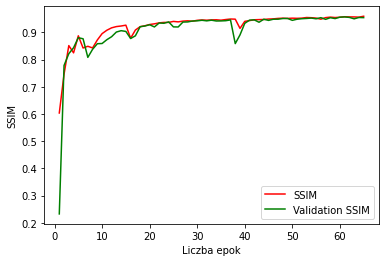

In [ ]:
epoch = range(1,66)
plt.plot(epoch,train_history.history['SSIM'], 'red', label='SSIM' )
plt.plot(epoch,train_history.history['val_SSIM'], 'green', label='Validation SSIM' )
plt.xlabel('Liczba epok')
plt.ylabel('SSIM')
plt.legend()
plt.show()

In [ ]:
loaded_model = tf.keras.models.load_model('drive/MyDrive/model/unet_resnet/23_11_7_5.h5',
                                          custom_objects = {'SSIM':SSIM, 'PSNR':PSNR, 'loss':ssim_loss},
                                          compile=True)

In [ ]:
images = []
for image in os.listdir('drive/MyDrive/baza/test_base/true_image_test/'):
  images.append(cv2.imread(f'drive/MyDrive/baza/test_base/true_image_test/{image}'))
images = np.array(images, dtype='object').astype('float32')
images = images / 255.

In [ ]:
pred = model.predict(images)

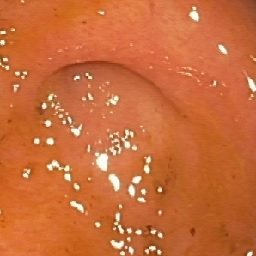

In [ ]:
cv2_imshow(images[0]*255)

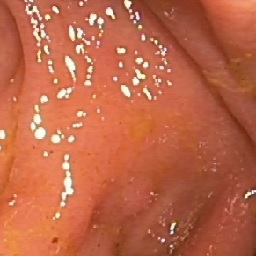

In [ ]:
cv2_imshow(images[2]*255)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  2432        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  25632       ['conv2d[0][0]']                 
                                )                                                             